Cross Validation 2

size = 121655

test size 4k+

epoch-5

apply sigmoid (prediction probabilities are logits)

groups-9

target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

threshold-tuning = yes

df_2k = df[(df['Rating'] >= 4.0) & (df['Maximum_Installs'] >= 5000)] 

accuracy score : F1 score (micro) and ROC_AUC score

#Part I - Setup and Dataset Prep

## 1. Setup

### 1.1. Using Colab GPU for Training

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
print(tf.__version__)

2.8.0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


### 1.2. Installing the Hugging Face Library

Next, let's install the [transformers](https://github.com/huggingface/transformers) package from Hugging Face which will give us a pytorch interface for working with BERT.

In [4]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.3 MB/s 
     |████████████████████████████████| 596 kB 66.8 MB/s 
     |████████████████████████████████| 6.5 MB 52.9 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 895 kB 61.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## 2. Retrieve and Inspect Dataset

### 2.1 Load dataset

In [5]:
## import libraries

import itertools
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn import preprocessing
%matplotlib inline

In [6]:
## uploading csv files on drive (to avoid uploading on colab in every session)

from google.colab import drive
drive.mount("/content/drive/")

## drive path
train_path = "/content/drive/MyDrive/MetadataCSV/data_121655/CV_df_train_2.csv"
val_path = "/content/drive/MyDrive/MetadataCSV/data_121655/CV_df_val_2.csv"
test_path = "/content/drive/MyDrive/MetadataCSV/test_dataset.csv"

Mounted at /content/drive/


In [7]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path) 
df_test = pd.read_csv(test_path)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(97324, 23)
(24331, 23)
(4624, 23)


In [8]:
df_train.head(2)

,App_Name,App_Id,Category,Rating,Maximum_Installs,Editors_Choice,Description,Privacy_Policy,Sensors,Camera,...,Contacts,SMS,Storage,Phone,Get_Accounts,Call_Log,desc_length,Clean_Description,clean_desc_length,token_length
0,Science Kids Learning - Be Super Scientist!,com.sciencegames.ScienceKidsLearning,Educational,4.2,78871,False,Science is all about inspiring curiosity and d...,https://nutboltgames.com/privacy-policy,0,0,...,0,0,1,0,0,0,1846,science is all about inspiring curiosity and d...,1807,343
1,Phuti kismat se Bhagyashali,com.photi.bhgysl,Lifestyle,4.4,13681,False,This year has in its fold mixed fate to offer ...,https://labtest12.wixsite.com/privacypolicy,0,0,...,0,0,0,0,0,0,1513,this year has in its fold mixed fate to offer ...,1443,350


In [9]:
target_list = ['Camera', 'Location', 'Microphone', 'Contacts', 'Storage', 'Phone', 'SMS', 'Call_Log', 'Calendar']

In [10]:
# getting number of nonzeros in each column
df_train[target_list].astype(bool).sum(axis=0)

Camera        16337
Location      16300
Microphone     8821
Contacts      10476
Storage       48246
Phone         15079
SMS             311
Call_Log        201
Calendar       1775
dtype: int64

In [11]:
df_val[target_list].astype(bool).sum(axis=0)

Camera         4116
Location       4042
Microphone     2220
Contacts       2644
Storage       12012
Phone          3798
SMS             102
Call_Log         65
Calendar        466
dtype: int64

In [12]:
df_test[target_list].astype(bool).sum(axis=0)

Camera         745
Location       716
Microphone     436
Contacts       500
Storage       2402
Phone          652
SMS             11
Call_Log         6
Calendar        90
dtype: int64

## 3. BERT Input Length Limitation

BERT has a maximum input length of 512 tokens. In this section, we'll look at how this limitation affects us in practice, and some possible approaches for addressing it,

### 3.1. Examples of 512 Tokens

First we'll need to load the BERT tokenizer.

In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

### 3.2. Strategies for longer text

Paper: How to Fine tune BERT for text classification - visit video :
https://www.youtube.com/watch?v=_eSGWNqKeeY&t=1117s
 and conference paper https://link.springer.com/chapter/10.1007/978-3-030-32381-3_16 for more details

### 3.3. Comment Length (Description) Distribution

To decide on a truncation strategy for this dataset, lets first look at the distribution of the comment lengths.

To do this, our first step is to tokenize all of the comments in the training set.

**Tokenize All Comments**

The `tokenizer.encode` function combines multiple steps for us:
1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.

In order to explore the distribution of descriptions length, we will not perform any truncation here. Unfortunately, this results in the tokenizer spitting out a warning for every description that's longer than 512 tokens. We'll just have to ignore those for now!

In [14]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [15]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])
print(df_acnet.shape)

(1414, 14)


In [16]:
train_clean_description = df_train.Clean_Description
#print(train_clean_description)

In [17]:
train_clean_description = train_clean_description.append(df_acnet.Clean_Description)
#print(train_clean_description)

In [18]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
train_input_ids = []

# Record the length of each sequence (after truncating to 512)
train_lengths = []

print('Tokenizing descriptions...')

# For every sentence...
for sent in train_clean_description:  #df_train.Clean_Description:

    # Report progress
    if ((len(train_input_ids) % 20000) == 0):
        print('   Read {:,} descriptions.'.format(len(train_input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    train_input_ids.append(encoded_sent)

    # Record the truncated length.
    train_lengths.append(len(encoded_sent))

print('DONE. ')
print('{:>10,} comments'.format(len(train_input_ids)))

Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors


Tokenizing descriptions...
   Read 0 descriptions.
   Read 20,000 descriptions.
   Read 40,000 descriptions.
   Read 60,000 descriptions.
   Read 80,000 descriptions.
DONE. 
    98,738 comments


In [19]:
import numpy as np

# Tokenize all of the sentences and map the tokens to thier word IDs.
val_input_ids = []

# Record the length of each sequence (after truncating to 512)
val_lengths = []

print('Tokenizing descriptions...')

# For every sentence...
for sent in df_val.Clean_Description:

    # Report progress
    if ((len(val_input_ids) % 20000) == 0):
        print('   Read {:,} descriptions.'.format(len(val_input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    val_input_ids.append(encoded_sent)

    # Record the truncated length.
    val_lengths.append(len(encoded_sent))

print('DONE. ')
print('{:>10,} comments'.format(len(val_input_ids)))

Tokenizing descriptions...
   Read 0 descriptions.
   Read 20,000 descriptions.
DONE. 
    24,331 comments


In [20]:
# Also retrieve the labels as a list

train_labels = df_train[target_list]
train_labels = train_labels.append(df_acnet[target_list])

validation_labels = df_val[target_list]

### 3.4. Pad & Truncate Comments

Truncate the descriptions to 512 tokens.

Not only that, but i think we can get away with an even shorter sequence length to speed things up. I have picked up a max length of 128, since this is around the "elbow" of the distribution.

We can always try longer lengths later to see how much this will omprove our result.

In [21]:
# We'll borrow the `pad_sequence` utility function to do this.

from keras.preprocessing.sequence import pad_sequences

#Set the required sentence length
MAX_LEN = 256   #128

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
train_inputs = pad_sequences(train_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

validation_inputs = pad_sequences(val_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0

Done.


**Attention Masks**

The attention mask simply makes it explicit which tokens are actual words versus which are padding.

The BERT vocabulary does not use the ID 0, so if a token ID is 0, then it's padding, and otherwise it's a real token. 

In [22]:
# Create attention masks
train_masks = []

# For each sentence...
for sent in train_inputs:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    train_masks.append(att_mask)

In [23]:
# Create attention masks
validation_masks = []

# For each sentence...
for sent in validation_inputs:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    validation_masks.append(att_mask)

### 3.5. Final Data Prep

In [24]:
### my code ---start

import pandas as pd

train_labels = train_labels.to_numpy()
validation_labels = validation_labels.to_numpy()

## my code ---end

2. Our model expects PyTorch tensors rather than numpy.ndarrays, so convert all of our dataset variables.

In [25]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.FloatTensor(train_labels)
validation_labels = torch.FloatTensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

3. We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16 #32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

#Part II - BERT Fine-Tuning

##4. Train our classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model.

###4.1. BertForSequenceClassification


**BertForSequenceClassification** - The one we'll use.


In [27]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    problem_type = "multi_label_classification",
    num_labels = 9, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks. IN OUR CASE - 9  ....6 
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

###4.2. Optimizer & Learning Rate Scheduler

In [28]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

###4.3. Training Loop

In each pass, we will train the model on our full training set, and then measure its accuracy on our 10% holdout validation set.

Define a helper function for calculating accuracy.

In [30]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def flat_accuracy(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= 0.5
    preds_th[:, 1] = np.array(preds[:, 1]) >= 0.5
    preds_th[:, 2] = np.array(preds[:, 2]) >= 0.5
    preds_th[:, 3] = np.array(preds[:, 3]) >= 0.5
    preds_th[:, 4] = np.array(preds[:, 4]) >= 0.5
    preds_th[:, 5] = np.array(preds[:, 5]) >= 0.5
    preds_th[:, 6] = np.array(preds[:, 6]) >= 0.5
    preds_th[:, 7] = np.array(preds[:, 7]) >= 0.5
    preds_th[:, 8] = np.array(preds[:, 8]) >= 0.5

    acc[0] = f1_score(labels[:, 0], preds_th[:, 0])
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1])
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2])
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3])
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4])
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5])
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6])
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7])
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8])

   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

Helper function for formatting elapsed times.

In [31]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [32]:
# Function for class weights

import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)

    print(class_series)
    print(class_labels)

    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])
    print(n_samples)
    print(n_classes)

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    #return dict(zip(class_labels, class_weights))
    return class_weights

In [33]:
class_series = np.array(train_labels)
class_wt = generate_class_weights(class_series, multi_class=False, one_hot_encoded=True)
print(class_wt)
class_wt = torch.tensor(class_wt)
print(class_wt)

98738
9
[0.6622533435282439, 0.6607377071120747, 1.2232009018718797, 1.0054888542653184, 0.22470738973207072, 0.7221015526156052, 20.97684299978755, 36.939019827908716, 5.8386848796641235]
tensor([ 0.6623,  0.6607,  1.2232,  1.0055,  0.2247,  0.7221, 20.9768, 36.9390,
         5.8387])


In [34]:
## Loss function with weights

def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss(pos_weight=class_wt)(outputs, targets)

We're ready to kick off the training!

In [35]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 100 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        #mycode-start
        class_wt = class_wt.to(device)
        #mycode-end

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)  
               #     labels=b_labels)

        ##mycode----start        
        optimizer.zero_grad()
        #print(outputs[0])
        #print(b_labels)
        loss = loss_fn(outputs[0], b_labels)
        optimizer.zero_grad()
        ##mycode----end

        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        #loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss = 0
    eval_accuracy = [0,0,0,0,0,0,0,0,0]
    tmp_eval_accuracy = [0,0,0,0,0,0,0,0,0]
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        #print('my_print_1')
        #print(logits)
        #print(label_ids)
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        #print('my_print_3')
        #print(tmp_eval_accuracy)
        
        # Accumulate the total accuracy.
        eval_accuracy[0] += tmp_eval_accuracy[0]
        eval_accuracy[1] += tmp_eval_accuracy[1]
        eval_accuracy[2] += tmp_eval_accuracy[2]
        eval_accuracy[3] += tmp_eval_accuracy[3]
        eval_accuracy[4] += tmp_eval_accuracy[4]
        eval_accuracy[5] += tmp_eval_accuracy[5]
        eval_accuracy[6] += tmp_eval_accuracy[6]
        eval_accuracy[7] += tmp_eval_accuracy[7]
        eval_accuracy[8] += tmp_eval_accuracy[8]
        

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy 0: {0:.2f}".format(eval_accuracy[0]/nb_eval_steps))
    print("  Accuracy 1: {0:.2f}".format(eval_accuracy[1]/nb_eval_steps))
    print("  Accuracy 2: {0:.2f}".format(eval_accuracy[2]/nb_eval_steps))
    print("  Accuracy 3: {0:.2f}".format(eval_accuracy[3]/nb_eval_steps))
    print("  Accuracy 4: {0:.2f}".format(eval_accuracy[4]/nb_eval_steps))
    print("  Accuracy 5: {0:.2f}".format(eval_accuracy[5]/nb_eval_steps))
    print("  Accuracy 6: {0:.2f}".format(eval_accuracy[6]/nb_eval_steps))
    print("  Accuracy 7: {0:.2f}".format(eval_accuracy[7]/nb_eval_steps))
    print("  Accuracy 8: {0:.2f}".format(eval_accuracy[8]/nb_eval_steps))


    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")

Output hidden; open in https://colab.research.google.com to view.

Let's take a look at our training loss over all batches:

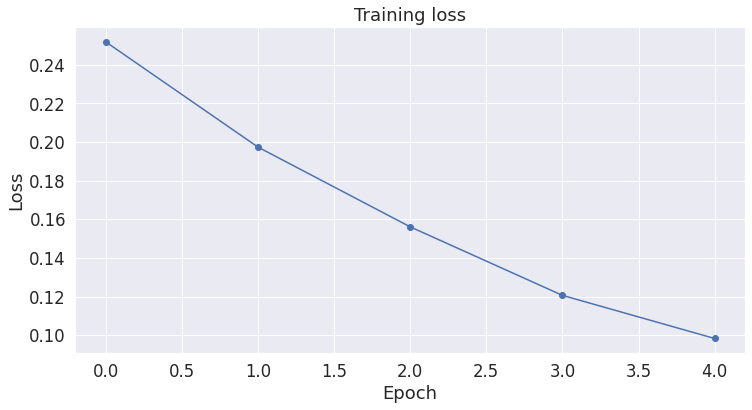

In [36]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set.

### 5.1. Data Preparation

We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [37]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
test_input_ids = []

# For every sentence...
for sent in df_test.Clean_Description:

    # Report the number of sentences.
    if((len(test_input_ids) % 20000) == 0):
        print(' Read {:,} comments'.format(len(test_input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.
                   )
    
    # Add the encoded sentence to the list
    test_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} test comments'.format(len(test_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the dataframe, and convert from booleans to ints
test_labels = df_test[target_list]

#print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
#print('{:>10,} negetive (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
test_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask) 

##my_code_start
test_labels = test_labels.to_numpy()
##my_code_ends

# Convert to tensors.
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


 Read 0 comments
DONE.

     4,624 test comments


### 5.2. Evaluate on Test Set

With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [38]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step,batch) in enumerate(test_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  #Progress update every 100 batches.
  if step % 100 == 0 and not step == 0:
      # Calculate elapsed time in minutes
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))


  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 4,624 test sentences...
  Batch   100 of   145. Elapsed: 0:00:26.
    DONE.


In [39]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [40]:
tensor_predictions = torch.tensor(predictions)

In [41]:
final_predictions = torch.sigmoid(tensor_predictions)

Let's peek at the model's output for the first 10 test samples, along with the correct label for each.

In [42]:
predictions[0:10]

array([[ -6.8204546 ,  -4.3815255 ,  -7.747317  ,  -6.2132125 ,
         -3.341046  ,  -5.2376614 ,  -9.273395  ,  -8.951829  ,
         -7.591666  ],
       [ -6.652782  ,  -5.47684   ,  -7.3397155 ,  -6.0649524 ,
         -3.2697268 ,  -4.790082  ,  -9.294217  ,  -9.0443735 ,
         -8.06527   ],
       [ -4.596361  ,  -3.7072606 ,  -5.5252485 ,  -4.9311643 ,
         -2.2195675 ,  -2.7978566 , -10.570114  , -10.072032  ,
         -8.316662  ],
       [ -5.6933303 ,  -5.1738853 ,  -8.025     ,  -5.6748815 ,
         -2.556809  ,  -3.8470566 ,  -9.201457  ,  -9.247397  ,
         -8.154401  ],
       [  0.06356241,  -2.3416874 ,  -5.577821  ,  -3.5049033 ,
         -0.31014282,   2.7448044 ,  -8.08003   ,  -7.92555   ,
         -6.67539   ],
       [ -3.966827  ,  -3.8891761 ,  -5.940674  ,  -3.228781  ,
         -0.8154346 ,  -3.8570783 ,  -9.335993  ,  -9.738938  ,
         -7.386905  ],
       [ -1.0271503 ,  -0.9717133 ,   3.4185565 ,   2.9427474 ,
         -0.41942865,   3.1061

In [43]:
final_predictions[0:10]

tensor([[1.0900e-03, 1.2352e-02, 4.3171e-04, 1.9988e-03, 3.4190e-02, 5.2846e-03,
         9.3880e-05, 1.2948e-04, 5.0438e-04],
        [1.2888e-03, 4.1651e-03, 6.4881e-04, 2.3175e-03, 3.6624e-02, 8.2433e-03,
         9.1946e-05, 1.1804e-04, 3.1417e-04],
        [9.9877e-03, 2.3957e-02, 3.9691e-03, 7.1664e-03, 9.8007e-02, 5.7440e-02,
         2.5671e-05, 4.2243e-05, 2.4435e-04],
        [3.3570e-03, 5.6306e-03, 3.2707e-04, 3.4193e-03, 7.1970e-02, 2.0896e-02,
         1.0088e-04, 9.6353e-05, 2.8738e-04],
        [5.1589e-01, 8.7729e-02, 3.7666e-03, 2.9173e-02, 4.2308e-01, 9.3962e-01,
         3.0957e-04, 3.6126e-04, 1.2600e-03],
        [1.8582e-02, 2.0052e-02, 2.6234e-03, 3.8097e-02, 3.0673e-01, 2.0692e-02,
         8.8184e-05, 5.8940e-05, 6.1893e-04],
        [2.6364e-01, 2.7454e-01, 9.6828e-01, 9.4992e-01, 3.9665e-01, 9.5715e-01,
         8.2321e-04, 5.6806e-03, 4.0206e-03],
        [8.3628e-01, 1.0367e-01, 9.6248e-01, 3.9748e-01, 9.0508e-01, 4.2141e-01,
         1.2368e-03, 1.7281e-0

In [44]:
true_labels[0:10]

array([[0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0]])

In [45]:
np.save("predictions.npy", predictions)
np.save("final_predictions.npy", final_predictions)

#loaded_predictions = np.load("predictions.npy")
loaded_predictions = np.load("final_predictions.npy")
print(loaded_predictions)

[[1.09003531e-03 1.23517904e-02 4.31713386e-04 ... 9.38804442e-05
  1.29483335e-04 5.04384981e-04]
 [1.28876406e-03 4.16510459e-03 6.48813962e-04 ... 9.19460072e-05
  1.18039461e-04 3.14167381e-04]
 [9.98771843e-03 2.39566602e-02 3.96906212e-03 ... 2.56712246e-05
  4.22429002e-05 2.44350667e-04]
 ...
 [5.09975731e-01 8.28821212e-02 1.06703885e-01 ... 7.87731042e-05
  1.13660717e-04 2.98977742e-04]
 [1.52549949e-02 8.75175297e-01 9.81092751e-01 ... 1.12436758e-02
  1.29837068e-02 1.21736107e-02]
 [2.09240825e-03 4.37022001e-03 1.37555692e-03 ... 6.40655635e-05
  9.25661370e-05 5.02548879e-04]]


In [46]:
np.save("true_labels.npy", true_labels)

loaded_true_labels = np.load("true_labels.npy")
print(loaded_true_labels)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [47]:
#predictions = np.load("predictions.npy")
predictions = np.load("final_predictions.npy")
true_labels = np.load("true_labels.npy")

In [48]:
#flat-score
eval_accuracy = flat_accuracy(predictions, true_labels)

# Report the final accuracy for this validation run.
print("  Accuracy 0: {0:.2f}".format(eval_accuracy[0]))
print("  Accuracy 1: {0:.2f}".format(eval_accuracy[1]))
print("  Accuracy 2: {0:.2f}".format(eval_accuracy[2]))
print("  Accuracy 3: {0:.2f}".format(eval_accuracy[3]))
print("  Accuracy 4: {0:.2f}".format(eval_accuracy[4]))
print("  Accuracy 5: {0:.2f}".format(eval_accuracy[5]))
print("  Accuracy 6: {0:.2f}".format(eval_accuracy[6]))
print("  Accuracy 7: {0:.2f}".format(eval_accuracy[7]))
print("  Accuracy 8: {0:.2f}".format(eval_accuracy[8]))

  Accuracy 0: 0.66
  Accuracy 1: 0.51
  Accuracy 2: 0.59
  Accuracy 3: 0.45
  Accuracy 4: 0.70
  Accuracy 5: 0.46
  Accuracy 6: 0.00
  Accuracy 7: 0.40
  Accuracy 8: 0.35


## 6. Threshold Calculation

In [49]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for data simulation
from sklearn.datasets import make_classification     # Create a synthetic dataframe
from sklearn.linear_model import LogisticRegression  # Classification model
from sklearn.model_selection import train_test_split # Split the dataframe
from sklearn.metrics import roc_curve                # Calculate the ROC curve
from sklearn.metrics import precision_recall_curve   # Calculate the Precision-Recall curve
from sklearn.metrics import f1_score                 # Calculate the F-score
# Import module for data visualization
from plotnine import *
import plotnine

In [50]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [51]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("final_predictions.npy")
  true_labels = np.load("true_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.405 with F-Score: 0.6808
permission  1
Length of sequence: 10000
Best Threshold: 0.172 with F-Score: 0.5958
permission  2
Length of sequence: 10000
Best Threshold: 0.4144 with F-Score: 0.5947
permission  3
Length of sequence: 10000
Best Threshold: 0.2045 with F-Score: 0.5353
permission  4
Length of sequence: 10000
Best Threshold: 0.0835 with F-Score: 0.7982
permission  5
Length of sequence: 10000
Best Threshold: 0.2172 with F-Score: 0.5339
permission  6
Length of sequence: 10000
Best Threshold: 0.1286 with F-Score: 0.1538
permission  7
Length of sequence: 10000
Best Threshold: 0.5203 with F-Score: 0.4444
permission  8
Length of sequence: 10000
Best Threshold: 0.7408 with F-Score: 0.3871
-------------------------------------
optimal threshold tuning for f-score
[0.405, 0.172, 0.4144, 0.2045, 0.0835, 0.2172, 0.1286, 0.5203, 0.7408]


In [52]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("final_predictions.npy")
  true_labels = np.load("true_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.06650000065565109 with G-Mean: 0.8462
FPR: 0.1268, TPR: 0.8201
permission  1
Best Threshold: 0.061799999326467514 with G-Mean: 0.7868
FPR: 0.1558, TPR: 0.7332
permission  2
Best Threshold: 0.02199999988079071 with G-Mean: 0.8433
FPR: 0.1528, TPR: 0.8394
permission  3
Best Threshold: 0.02329999953508377 with G-Mean: 0.8034
FPR: 0.2204, TPR: 0.828
permission  4
Best Threshold: 0.15199999511241913 with G-Mean: 0.785
FPR: 0.1904, TPR: 0.761
permission  5
Best Threshold: 0.061000000685453415 with G-Mean: 0.7732
FPR: 0.1979, TPR: 0.7454
permission  6
Best Threshold: 0.0008999999845400453 with G-Mean: 0.7435
FPR: 0.1314, TPR: 0.6364
permission  7
Best Threshold: 0.002400000113993883 with G-Mean: 0.8856
FPR: 0.0589, TPR: 0.8333
permission  8
Best Threshold: 0.0035000001080334187 with G-Mean: 0.7853
FPR: 0.146, TPR: 0.7222
-------------------------------------
ROC curve with G-mean threshold tuning
[0.0665, 0.0618, 0.022, 0.0233, 0.152, 0.061, 0.0009, 0.0024, 0.0

## 7. Performance Score

In [ ]:
#Fscore micro for different thresholds-

In [53]:
#predictions = np.load("predictions.npy")
predictions = np.load("final_predictions.npy")
true_labels = np.load("true_labels.npy")

In [54]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f_at_1(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

   
    acc[0] = f1_score(labels[:, 0], preds_th[:, 0])
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1])
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2])
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3])
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4])
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5])
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6])
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7])
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8])

   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [55]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("F1_CV2_N121k_Bert.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.6808
  Location  : 0.5958
  Microphone: 0.5947
  Contacts  : 0.5353
  Storage   : 0.7982
  Phone     : 0.5339
  SMS       : 0.1538
  Call_Log  : 0.4444
  Calendar  : 0.3871

  Average F1 score: 0.5249


In [ ]:
#Fscore micro for different thresholds-

In [56]:
#predictions = np.load("predictions.npy")
predictions = np.load("final_predictions.npy")
true_labels = np.load("true_labels.npy")

In [57]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import f1_score

def f1micro_accuracy(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_f[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_f[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_f[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_f[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_f[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_f[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_f[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_f[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_f[8]

    acc[0] = f1_score(labels[:, 0], preds_th[:, 0], average='micro')
    acc[1] = f1_score(labels[:, 1], preds_th[:, 1], average='micro')
    acc[2] = f1_score(labels[:, 2], preds_th[:, 2], average='micro')
    acc[3] = f1_score(labels[:, 3], preds_th[:, 3], average='micro')
    acc[4] = f1_score(labels[:, 4], preds_th[:, 4], average='micro')
    acc[5] = f1_score(labels[:, 5], preds_th[:, 5], average='micro')
    acc[6] = f1_score(labels[:, 6], preds_th[:, 6], average='micro')
    acc[7] = f1_score(labels[:, 7], preds_th[:, 7], average='micro')
    acc[8] = f1_score(labels[:, 8], preds_th[:, 8], average='micro')
    
   #f1_score_micro = metrics.f1_score(targets, outputs, average='micro')

    #print(acc)
    return acc

In [58]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("F1Mic_CV2_N121k_Bert.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.9053
  Location  : 0.8750
  Microphone: 0.9269
  Contacts  : 0.8960
  Storage   : 0.7811
  Phone     : 0.8648
  SMS       : 0.9952
  Call_Log  : 0.9989
  Calendar  : 0.9836

  Average F1 (micro) score: 0.9141


In [ ]:
#roc-auc score for different thresholds-

In [59]:
import numpy as np
#predictions = np.load("predictions.npy")
predictions = np.load("final_predictions.npy")
true_labels = np.load("true_labels.npy")

In [60]:
# Function to calculate the accuracy of our predictions vs labels

import numpy as np
from sklearn.metrics import roc_auc_score

def roc_auc(preds, labels):
    #print('my_print_2')
    acc = [0, 0 ,0 ,0 ,0 ,0, 0, 0, 0]
    preds_th = preds
    
    preds_th[:, 0] = np.array(preds[:, 0]) >= thresh_roc[0]
    preds_th[:, 1] = np.array(preds[:, 1]) >= thresh_roc[1]
    preds_th[:, 2] = np.array(preds[:, 2]) >= thresh_roc[2]
    preds_th[:, 3] = np.array(preds[:, 3]) >= thresh_roc[3]
    preds_th[:, 4] = np.array(preds[:, 4]) >= thresh_roc[4]
    preds_th[:, 5] = np.array(preds[:, 5]) >= thresh_roc[5]
    preds_th[:, 6] = np.array(preds[:, 6]) >= thresh_roc[6]
    preds_th[:, 7] = np.array(preds[:, 7]) >= thresh_roc[7]
    preds_th[:, 8] = np.array(preds[:, 8]) >= thresh_roc[8]


    acc[0] = roc_auc_score(labels[:, 0], preds_th[:, 0])
    acc[1] = roc_auc_score(labels[:, 1], preds_th[:, 1])
    acc[2] = roc_auc_score(labels[:, 2], preds_th[:, 2])
    acc[3] = roc_auc_score(labels[:, 3], preds_th[:, 3])
    acc[4] = roc_auc_score(labels[:, 4], preds_th[:, 4])
    acc[5] = roc_auc_score(labels[:, 5], preds_th[:, 5])
    acc[6] = roc_auc_score(labels[:, 6], preds_th[:, 6])
    acc[7] = roc_auc_score(labels[:, 7], preds_th[:, 7])
    acc[8] = roc_auc_score(labels[:, 8], preds_th[:, 8])
   

    #print(acc)
    return acc

In [61]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("ROC_CV2_N121k_Bert.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8461
  Location  : 0.7880
  Microphone: 0.8433
  Contacts  : 0.8032
  Storage   : 0.7851
  Phone     : 0.7736
  SMS       : 0.7083
  Call_Log  : 0.8042
  Calendar  : 0.7877

  Average ROC_AUC score: 0.7933


# ACNET Performance

#### a) Data Preparation

In [62]:
## drive path
acnet_path = "/content/drive/MyDrive/MetadataCSV/acnet_dataset_preprocess.csv"

In [63]:
df_acnet = pd.read_csv(acnet_path) 
print(df_acnet.shape)

(1417, 14)


In [64]:
df_acnet = df_acnet.dropna(subset=['Clean_Description'])

In [65]:
df_acnet.head()

,app_id,description,Storage,Contacts,Location,Camera,Microphone,SMS,Call_Log,Phone,Calendar,Settings,Tasks,Clean_Description
0,0,ROOT is REQUIRED for automatic synchronization...,1,0,1,0,0,0,0,0,0,0,0,root is required for automatic synchronization...
1,1,This app delivers short scriptures containing ...,0,0,0,0,0,1,0,0,0,0,0,this app delivers short scriptures containing ...
2,2,This game is surprisingly simple and very addi...,0,0,0,0,0,0,0,0,0,0,0,this game is surprisingly simple and very addi...
3,3,It is an online RPG game based on LBS location...,0,0,1,0,0,0,0,0,0,0,0,it is an online rpg game based on lbs location...
4,4,Christmas is in the air. Get yourself in the h...,0,1,0,0,0,0,0,0,0,1,1,christmas is in the air. get yourself in the h...


In [66]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
acnet_input_ids = []

# For every sentence...
for sent in df_acnet.Clean_Description:

    # Report the number of sentences.
    if((len(acnet_input_ids) % 20000) == 0):
        print(' Read {:,} comments'.format(len(acnet_input_ids)))

    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LEN,       # Truncate all sentences.
                   )
    
    # Add the encoded sentence to the list
    acnet_input_ids.append(encoded_sent)

print('DONE.')
print('')
print('{:>10,} acnet comments'.format(len(acnet_input_ids)))

# Also retrieve the labels as a list.

# Get the labels from the dataframe, and convert from booleans to ints
acnet_labels = df_acnet[target_list]

#print('{:>10,} positive (contains attack)'.format(np.sum(test_labels)))
#print('{:>10,} negetive (not an attack)'.format(len(test_labels) - np.sum(test_labels)))

# Pad our input tokens
acnet_input_ids = pad_sequences(acnet_input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
acnet_attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in acnet_input_ids:
  seq_mask = [float(i>0) for i in seq]
  acnet_attention_masks.append(seq_mask) 

##my_code_start
acnet_labels = acnet_labels.to_numpy()
##my_code_ends

# Convert to tensors.
acnet_inputs = torch.tensor(acnet_input_ids)
acnet_masks = torch.tensor(acnet_attention_masks)
acnet_labels = torch.tensor(acnet_labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
acnet_data = TensorDataset(acnet_inputs, acnet_masks, acnet_labels)
acnet_sampler = SequentialSampler(acnet_data)
acnet_dataloader = DataLoader(acnet_data, sampler=acnet_sampler, batch_size=batch_size)

 Read 0 comments
DONE.

     1,414 acnet comments


#### b) Get Predictions

In [67]:
# Prediction on acnet set

print('Predicting labels for {:,} test sentences...'.format(len(acnet_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Measure elapsed time.
t0 = time.time()

# Predict 
for (step,batch) in enumerate(acnet_dataloader):
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  #Progress update every 100 batches.
  if step % 100 == 0 and not step == 0:
      # Calculate elapsed time in minutes
      elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(acnet_dataloader), elapsed))


  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 1,414 test sentences...
    DONE.


In [68]:
# Combine the results across the batches.
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

In [69]:
tensor_predictions = torch.tensor(predictions)
final_predictions = torch.sigmoid(tensor_predictions)

In [70]:
np.save("acnet_predictions.npy", final_predictions)
loaded_predictions = np.load("acnet_predictions.npy")

np.save("acnet_labels.npy", true_labels)
loaded_true_labels = np.load("acnet_labels.npy")

#### c) Threshold Calculation

In [71]:
thresh_f = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
thresh_roc = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [72]:
n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  # Array for finding the optimal threshold
  thresholds = np.arange(0.0, 1.0, 0.0001)
  fscore = np.zeros(shape=(len(thresholds)))
  print('Length of sequence: {}'.format(len(thresholds)))

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Fit the model
  for index, elem in enumerate(thresholds):
    # Corrected probabilities
    y_pred_prob = (pred > elem).astype('int')
    # Calculate the f-score
    fscore[index] = f1_score(labels, y_pred_prob)

  # Find the optimal threshold
  index = np.argmax(fscore)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  fscoreOpt = round(fscore[index], ndigits = 4)
  thresh_f[i] = thresholdOpt
  print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

print("-------------------------------------")
print("optimal threshold tuning for f-score")
print(thresh_f)

permission  0
Length of sequence: 10000
Best Threshold: 0.2432 with F-Score: 0.7982
permission  1
Length of sequence: 10000
Best Threshold: 0.2883 with F-Score: 0.8068
permission  2
Length of sequence: 10000
Best Threshold: 0.434 with F-Score: 0.9276
permission  3
Length of sequence: 10000
Best Threshold: 0.1204 with F-Score: 0.8267
permission  4
Length of sequence: 10000
Best Threshold: 0.0762 with F-Score: 0.6676
permission  5
Length of sequence: 10000
Best Threshold: 0.3643 with F-Score: 0.6118
permission  6
Length of sequence: 10000
Best Threshold: 0.3467 with F-Score: 0.968
permission  7
Length of sequence: 10000
Best Threshold: 0.8917 with F-Score: 0.9305
permission  8
Length of sequence: 10000
Best Threshold: 0.6541 with F-Score: 0.9758
-------------------------------------
optimal threshold tuning for f-score
[0.2432, 0.2883, 0.434, 0.1204, 0.0762, 0.3643, 0.3467, 0.8917, 0.6541]


In [73]:
##for roc curve with g-mean

n = 9
for i in range(0, n):
  print('permission ',i)

  predictions = np.load("acnet_predictions.npy")
  true_labels = np.load("acnet_labels.npy")

  labels = true_labels[:, i]
  pred = predictions[:, i]

  # Create the ROC curve
  fpr, tpr, thresholds = roc_curve(labels, pred)

  df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

  # Calculate the G-mean
  gmean = np.sqrt(tpr * (1 - fpr))

  # Find the optimal threshold
  index = np.argmax(gmean)
  thresholdOpt = round(thresholds[index], ndigits = 4)
  gmeanOpt = round(gmean[index], ndigits = 4)
  fprOpt = round(fpr[index], ndigits = 4)
  tprOpt = round(tpr[index], ndigits = 4)

  thresh_roc[i] = thresholdOpt
  print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
  print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))

print("-------------------------------------")
print("ROC curve with G-mean threshold tuning")
print(thresh_roc)

permission  0
Best Threshold: 0.16189999878406525 with G-Mean: 0.8887
FPR: 0.0819, TPR: 0.8603
permission  1
Best Threshold: 0.15119999647140503 with G-Mean: 0.9031
FPR: 0.1144, TPR: 0.9211
permission  2
Best Threshold: 0.36880001425743103 with G-Mean: 0.9725
FPR: 0.0142, TPR: 0.9595
permission  3
Best Threshold: 0.12049999833106995 with G-Mean: 0.8966
FPR: 0.1573, TPR: 0.954
permission  4
Best Threshold: 0.15539999306201935 with G-Mean: 0.7016
FPR: 0.2736, TPR: 0.6776
permission  5
Best Threshold: 0.19059999287128448 with G-Mean: 0.8597
FPR: 0.1223, TPR: 0.8421
permission  6
Best Threshold: 0.41769999265670776 with G-Mean: 0.9942
FPR: 0.0116, TPR: 1.0
permission  7
Best Threshold: 0.2784000039100647 with G-Mean: 0.987
FPR: 0.0258, TPR: 1.0
permission  8
Best Threshold: 0.3167000114917755 with G-Mean: 0.9931
FPR: 0.0137, TPR: 1.0
-------------------------------------
ROC curve with G-mean threshold tuning
[0.1619, 0.1512, 0.3688, 0.1205, 0.1554, 0.1906, 0.4177, 0.2784, 0.3167]


#### d) Accuracy Score

In [ ]:
#Fscore micro for different thresholds-

In [74]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [75]:
eval_accuracy = f_at_1(predictions, true_labels)

np.save("ACNET_F1_CV2_N121k_Bert.npy", eval_accuracy)

# Report the final accuracy for this validation run.
print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")
avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 score: {0:.4f}".format(avg_score))

  Camera    : 0.7982
  Location  : 0.8068
  Microphone: 0.9276
  Contacts  : 0.8267
  Storage   : 0.6676
  Phone     : 0.6118
  SMS       : 0.9680
  Call_Log  : 0.9305
  Calendar  : 0.9758

  Average F1 score: 0.8348


In [ ]:
#Fscore micro for different thresholds-

In [76]:
#predictions = np.load("predictions.npy")
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [77]:
eval_accuracy = f1micro_accuracy(predictions, true_labels)

np.save("ACNET_F1Mic_CV2_N121k_Bert.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average F1 (micro) score: {0:.4f}".format(avg_score))

  Camera    : 0.9349
  Location  : 0.9194
  Microphone: 0.9844
  Contacts  : 0.8769
  Storage   : 0.6655
  Phone     : 0.9300
  SMS       : 0.9901
  Call_Log  : 0.9908
  Calendar  : 0.9965

  Average F1 (micro) score: 0.9209


In [ ]:
#roc-auc score for different thresholds-

In [78]:
import numpy as np
predictions = np.load("acnet_predictions.npy")
true_labels = np.load("acnet_labels.npy")

In [79]:
#roc-auc score

eval_accuracy = roc_auc(predictions, true_labels)

np.save("ACNET_ROC_CV2_N121k_Bert.npy", eval_accuracy)

# Report the final accuracy for this validation run.

print("  Camera    : {0:.4f}".format(eval_accuracy[0]))
print("  Location  : {0:.4f}".format(eval_accuracy[1]))
print("  Microphone: {0:.4f}".format(eval_accuracy[2]))
print("  Contacts  : {0:.4f}".format(eval_accuracy[3]))
print("  Storage   : {0:.4f}".format(eval_accuracy[4]))
print("  Phone     : {0:.4f}".format(eval_accuracy[5]))
print("  SMS       : {0:.4f}".format(eval_accuracy[6]))
print("  Call_Log  : {0:.4f}".format(eval_accuracy[7]))
print("  Calendar  : {0:.4f}".format(eval_accuracy[8]))

print("")

avg_score = (np.sum(eval_accuracy, dtype = np.float32)) / 9
print("  Average ROC_AUC score: {0:.4f}".format(avg_score))

  Camera    : 0.8892
  Location  : 0.9000
  Microphone: 0.9726
  Contacts  : 0.8972
  Storage   : 0.7020
  Phone     : 0.8555
  SMS       : 0.9942
  Call_Log  : 0.9871
  Calendar  : 0.9883

  Average ROC_AUC score: 0.9096
